# Preprocess the dataframe

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sb
import pingouin as pg
import random
import os
from statsmodels.formula.api import ols
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 20,
         'axes.titlesize':16,
         'axes.labelcolor':"#000000",
         'xtick.labelsize':20,
         'ytick.labelsize':16,
         'font.weight':"normal",
         'xtick.color':"#000000",
         'ytick.color':"#000000",
         'axes.labelweight':'normal'}
pylab.rcParams.update(params)
%matplotlib inline

data_src = './cloud_results/'
save_dir = f'./statistics/new/'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

In [33]:
def Variable2Vitual(df, attribute, values=None):
    # convert a multi-value attribute column to multiple virtual variables
    if values is None:
        values = set(df[attribute])
    for v in values:
        df[f'is_{v}'] = (df[attribute]==v).astype(int)
    return df

def read_cloud(csv_path, cloud_name):
    # preprocess the csv data
    data = pd.read_csv(csv_path)
    data['Attack'] = data['Attack'].str.upper()
    data['Attack'][data['Attack'] == 'BL-BFGS'] = 'BLB'
    data['is_Pretrained'] = data['Pretrained'].astype(int)
    data['local_success_rate'] = data['total']/200
    data['cloud'] = cloud_name
    return data

def export_ols(ols_result, filename):
    with open(filename, 'w') as f:
        f.write(ols_result.summary().as_csv())

dataset = 'imagenet'
df_list = []
for cloud in ['aliyun', 'baidu', 'google', 'aws']:
    csv_path = data_src+f'{cloud}_{dataset}.csv'
    df = read_cloud(csv_path, cloud)
    df_list.append(df)
data = pd.concat(df_list, axis=0)
data.head()

,Architecture,Data_type,Depth,Pretrained,Attack,misclassification_rate,matching_rate,total,mis_ratio,match_ratio,Unnamed: 10,is_Pretrained,local_success_rate,cloud
0,resnet,raw,18,True,BLB,0.000000,0.120000,200,0.000,0.120,NaN,1,1.000,aliyun
1,resnet,raw,18,True,CW2,0.005000,0.115000,200,0.005,0.115,NaN,1,1.000,aliyun
2,resnet,raw,18,True,DEEPFOOL,0.000000,0.114583,192,0.000,0.110,NaN,1,0.960,aliyun
3,resnet,raw,18,True,FGSM,0.163043,0.195652,184,0.150,0.180,NaN,1,0.920,aliyun
4,resnet,raw,18,True,LLC,0.052910,0.026455,189,0.050,0.025,NaN,1,0.945,aliyun


In [34]:
# reformalize data
for attr in ['Architecture', 'Data_type', 'Attack', 'cloud']:
    data = Variable2Vitual(data, attr)
data = Variable2Vitual(data, 'Depth', ['18', '34', '50'])
# remove unnecessary columns
df = data.drop(['Architecture', 'Data_type', 'Attack', 'Depth', 'total', 'Pretrained', 'mis_ratio', 'match_ratio', 'cloud', 'local_success_rate'], axis=1)
res_df = df[df['is_resnet']==1].copy(deep=True).reset_index(drop=True)
df.head()

,misclassification_rate,matching_rate,Unnamed: 10,is_Pretrained,is_resnet,is_inception,is_vgg,is_raw,is_augmented,is_adversarial,...,is_RFGSM,is_LLC,is_BLB,is_google,is_aliyun,is_aws,is_baidu,is_18,is_34,is_50
0,0.000000,0.120000,NaN,1,1,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
1,0.005000,0.115000,NaN,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0.000000,0.114583,NaN,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0.163043,0.195652,NaN,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0.052910,0.026455,NaN,1,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0


In [35]:
# visualize all the columns
df.columns

Index(['misclassification_rate', 'matching_rate', 'Unnamed: 10',
       'is_Pretrained', 'is_resnet', 'is_inception', 'is_vgg', 'is_raw',
       'is_augmented', 'is_adversarial', 'is_CW2', 'is_FGSM', 'is_DEEPFOOL',
       'is_UAP', 'is_PGD', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_BLB',
       'is_google', 'is_aliyun', 'is_aws', 'is_baidu', 'is_18', 'is_34',
       'is_50'],
      dtype='object')

# The large OLS table and statistical tests

In [36]:
# Two methods for comparing coefficients. We use Wald's R test 

# def Generate_Compare_Formula(original_formula, compare_v1, compare_v2):
#     # helper func for generating formula for compare two factors
#     # It removes v1 and v2 from the formula, but adds v1+v2 and v1-v2.
#     # Assume the regression coefficient of v1+v2 is x and the coefficient of v1-v2 is y.
#     # If y>0 significantly, then the regression model x(v1+v2)+y(v1-v2) = (x+y)v1 + (x-y)v2, and thus the coefficient of v2 is less than v1 since x-y < x+y. The p-value of the test y<=0 is thus a valid p-value for the latter.
#     original_formula = original_formula + f'-{compare_v1}-{compare_v2}'
#     original_formula += f'+I({compare_v1}+{compare_v2})+I({compare_v2}-{compare_v1})'
#     return original_formula

def Test_Wald_R(ols_result, R_coef:list, R_var_name:list, return_result=False):
    # Test H0: R * coef = 0.
    # e.g. For R_coef = [1,-1], coef = [is_aliyun, is_baidu], this tests H0: is_aliyun - is_baidu = 0, which is equivalent to test H0: is_aliyun = is_baidu.
    # this is used to compare the coefficients of variables.
    assert len(R_coef) == len(R_var_name), 'One to one map should be given.'
    params = ols_result.params
    idx_map = dict([(list(params.index)[i], i) for i in range(len(list(params.index)))])
    R = np.zeros(len(params))
    for r, var in zip(R_coef, R_var_name):
        R[idx_map[var]] = r
    test = ols_result.wald_test(R, scalar=False)
    print(test.summary())
    if return_result:
        return test

## Regression A

dependent variable: misclassification rate

explain variables: platform

In [37]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun']

dp_variable = 'misclassification_rate'
# dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

misclassification_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     misclassification_rate   R-squared:                       0.645
Model:                                OLS   Adj. R-squared:                  0.644
Method:                     Least Squares   F-statistic:                     390.8
Date:                    Tue, 15 Mar 2022   Prob (F-statistic):          1.64e-144
Time:                            21:16:14   Log-Likelihood:                 963.09
No. Observations:                     648   AIC:                            -1918.
Df Residuals:                         644   BIC:                            -1900.
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
is_google      0.2319      0.004     53.761      0.000       0.223       0.240
is_aws         0.0710      0.004     16.449      0.000       0.062       0.079
is_baidu       0.1929      0.004     44.705      0.000       0.184       0.201
is_aliyun      0.0638      0.004     14.788      0.000       0.055       0.072
==============================================================================
Omnibus:                       60.330   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.851
Skew:                           0.836   Prob(JB):                     3.38e-17
Kurtosis:                       3.115   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Test platform coefficients for misclassification rate

In [38]:
# Result:  aliyun \approx AWS < Baidu < Google
# The order is due to the coefficient value. We test for the significance of the inequality.

Test_Wald_R(results, [1, -1], ['is_aliyun', 'is_aws'])
Test_Wald_R(results, [1, -1], ['is_aws', 'is_baidu'])
Test_Wald_R(results, [1, -1], ['is_baidu', 'is_google'])

<F test: F=array([[1.37980878]]), p=0.24056787472459856, df_denom=644, df_num=1>
<F test: F=array([[399.17806853]]), p=1.7975273919482555e-69, df_denom=644, df_num=1>
<F test: F=array([[41.01062508]]), p=2.920532273707875e-10, df_denom=644, df_num=1>


## Regression B

dependent variable: misclassification rate

explain variables: platform + pretraining + dataset

In [39]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented']

dp_variable = 'misclassification_rate'
# dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

misclassification_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     misclassification_rate   R-squared:                       0.656
Model:                                OLS   Adj. R-squared:                  0.653
Method:                     Least Squares   F-statistic:                     204.1
Date:                    Tue, 15 Mar 2022   Prob (F-statistic):          4.60e-145
Time:                            21:16:14   Log-Likelihood:                 973.25
No. Observations:                     648   AIC:                            -1933.
Df Residuals:                         641   BIC:                            -1901.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_google          0.2362      0.006     41.938      0.000       0.225       0.247
is_aws             0.0752      0.006     13.354      0.000       0.064       0.086
is_baidu           0.1971      0.006     35.000      0.000       0.186       0.208
is_aliyun          0.0680      0.006     12.082      0.000       0.057       0.079
is_Pretrained     -0.0176      0.004     -4.129      0.000      -0.026      -0.009
is_adversarial     0.0095      0.005      1.832      0.067      -0.001       0.020
is_augmented       0.0041      0.005      0.787      0.431      -0.006       0.014
==============================================================================
Omnibus:                       54.958   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               67.327
Skew:                           0.785   Prob(JB):                     2.40e-15
Kurtosis:                       3.169   Cond. No.                         4.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression C

dependent variable: misclassification rate

explain variables: platform + pretraining + dataset + adversarial algorithm

In [75]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC']

dp_variable = 'misclassification_rate'
# dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

misclassification_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     misclassification_rate   R-squared:                       0.899
Model:                                OLS   Adj. R-squared:                  0.896
Method:                     Least Squares   F-statistic:                     401.0
Date:                    Thu, 17 Mar 2022   Prob (F-statistic):          1.63e-303
Time:                            23:40:29   Log-Likelihood:                 1368.9
No. Observations:                     648   AIC:                            -2708.
Df Residuals:                         633   BIC:                            -2641.
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_google          0.2354      0.005     52.259      0.000       0.227       0.244
is_aws             0.0744      0.005     16.526      0.000       0.066       0.083
is_baidu           0.1963      0.005     43.585      0.000       0.187       0.205
is_aliyun          0.0673      0.005     14.935      0.000       0.058       0.076
is_Pretrained     -0.0176      0.002     -7.556      0.000      -0.022      -0.013
is_adversarial     0.0095      0.003      3.352      0.001       0.004       0.015
is_augmented       0.0041      0.003      1.441      0.150      -0.001       0.010
is_PGD             0.0030      0.005      0.608      0.544      -0.007       0.013
is_FGSM            0.0727      0.005     14.738      0.000       0.063       0.082
is_BLB            -0.0481      0.005     -9.748      0.000      -0.058      -0.038
is_CW2            -0.0470      0.005     -9.524      0.000      -0.057      -0.037
is_DEEPFOOL       -0.0497      0.005    -10.070      0.000      -0.059      -0.040
is_STEP_LLC        0.0783      0.005     15.876      0.000       0.069       0.088
is_RFGSM        -2.91e-05      0.005     -0.006      0.995      -0.010       0.010
is_LLC            -0.0024      0.005     -0.493      0.622      -0.012       0.007
==============================================================================
Omnibus:                      115.085   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              320.881
Skew:                           0.880   Prob(JB):                     2.10e-70
Kurtosis:                       5.965   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Test adversarial algorithms

In [76]:
# Result: DEEPFOOL \approx BLB \approx CW2 < LLC \approx RFGSM \approx UAP \approx LLC \approx PGD < FGSM \approx Step-LLC
# Same rationale as before (order due to value, test for inequality).

Test_Wald_R(results, [1, -1], ['is_DEEPFOOL', 'is_BLB'])
Test_Wald_R(results, [1, -1], ['is_BLB', 'is_CW2'])
Test_Wald_R(results, [1, -1], ['is_CW2', 'is_LLC'])
# UAP here because the attacks above have negative coefficient and attacks below have positive coefficient. UAP is the baseline and thus is viewed as zero coefficient.
Test_Wald_R(results, [1, -1], ['is_LLC', 'is_PGD'])
Test_Wald_R(results, [1, -1], ['is_PGD', 'is_FGSM'])
Test_Wald_R(results, [1, -1], ['is_FGSM', 'is_STEP_LLC'])

<F test: F=array([[0.10352613]]), p=0.7477447076333341, df_denom=633, df_num=1>
<F test: F=array([[0.05018513]]), p=0.8228137375550341, df_denom=633, df_num=1>
<F test: F=array([[81.54999584]]), p=2.0425121893283545e-18, df_denom=633, df_num=1>
<F test: F=array([[1.21176425]]), p=0.2714014169036055, df_denom=633, df_num=1>
<F test: F=array([[199.65681631]]), p=1.3359421443338588e-39, df_denom=633, df_num=1>
<F test: F=array([[1.29662808]]), p=0.2552608195459125, df_denom=633, df_num=1>


## Regression D

dependent variable: misclassification rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth

In [42]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

dp_variable = 'misclassification_rate'
# dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

misclassification_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     misclassification_rate   R-squared:                       0.899
Model:                                OLS   Adj. R-squared:                  0.896
Method:                     Least Squares   F-statistic:                     350.2
Date:                    Tue, 15 Mar 2022   Prob (F-statistic):          4.63e-301
Time:                            21:16:15   Log-Likelihood:                 1369.3
No. Observations:                     648   AIC:                            -2705.
Df Residuals:                         631   BIC:                            -2628.
Df Model:                              16                                         
Covariance Type:                nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_google          0.2341      0.005     48.761      0.000       0.225       0.244
is_aws             0.0731      0.005     15.231      0.000       0.064       0.083
is_baidu           0.1950      0.005     40.623      0.000       0.186       0.204
is_aliyun          0.0659      0.005     13.738      0.000       0.057       0.075
is_Pretrained     -0.0176      0.002     -7.548      0.000      -0.022      -0.013
is_adversarial     0.0095      0.003      3.348      0.001       0.004       0.015
is_augmented       0.0041      0.003      1.439      0.151      -0.001       0.010
is_PGD             0.0030      0.005      0.607      0.544      -0.007       0.013
is_FGSM            0.0727      0.005     14.722      0.000       0.063       0.082
is_BLB            -0.0481      0.005     -9.738      0.000      -0.058      -0.038
is_CW2            -0.0470      0.005     -9.514      0.000      -0.057      -0.037
is_DEEPFOOL       -0.0497      0.005    -10.059      0.000      -0.059      -0.040
is_STEP_LLC        0.0783      0.005     15.860      0.000       0.069       0.088
is_RFGSM        -2.91e-05      0.005     -0.006      0.995      -0.010       0.010
is_LLC            -0.0024      0.005     -0.493      0.622      -0.012       0.007
is_34              0.0023      0.003      0.809      0.419      -0.003       0.008
is_50              0.0017      0.003      0.588      0.556      -0.004       0.007
==============================================================================
Omnibus:                      115.618   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              318.136
Skew:                           0.888   Prob(JB):                     8.27e-70
Kurtosis:                       5.937   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression E

dependent variable: misclassification rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth + cross terms

In [43]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

dp_variable = 'misclassification_rate'
# dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

misclassification_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50+I(is_Pretrained*is_adversarial)+I(is_Pretrained*is_augmented)+I(is_Pretrained*is_34)+I(is_Pretrained*is_50)+I(is_adversarial*is_34)+I(is_adversarial*is_50)+I(is_augmented*is_34)+I(is_augmented*is_50)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     misclassification_rate   R-squared:                       0.902
Model:                                OLS   Adj. R-squared:                  0.898
Method:                     Least Squares   F-statistic:                     238.2
Date:                    Tue, 15 Mar 2022   Prob (F-statistic):          3.52e-295
Time:                            21:16:15   Log-Likelihood:                 1378.9
No. Observations:                     648   AIC:                            -2708.
Df Residuals:                         623   BIC:                            -2596.
Df Model:                              24                                         
Covariance Type:                nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
is_google                             0.2335      0.006     40.454      0.000       0.222       0.245
is_aws                                0.0726      0.006     12.569      0.000       0.061       0.084
is_baidu                              0.1944      0.006     33.686      0.000       0.183       0.206
is_aliyun                             0.0654      0.006     11.327      0.000       0.054       0.077
is_Pretrained                        -0.0139      0.005     -2.699      0.007      -0.024      -0.004
is_adversarial                        0.0047      0.006      0.836      0.404      -0.006       0.016
is_augmented                          0.0136      0.006      2.400      0.017       0.002       0.025
is_PGD                                0.0030      0.005      0.612      0.541      -0.007       0.013
is_FGSM                               0.0727      0.005     14.848      0.000       0.063       0.082
is_BLB                               -0.0481      0.005     -9.821      0.000      -0.058      -0.038
is_CW2                               -0.0470      0.005     -9.595      0.000      -0.057      -0.037
is_DEEPFOOL                          -0.0497      0.005    -10.145      0.000      -0.059      -0.040
is_STEP_LLC                           0.0783      0.005     15.995      0.000       0.069       0.088
is_RFGSM                           -2.91e-05      0.005     -0.006      0.995      -0.010       0.010
is_LLC                               -0.0024      0.005     -0.497      0.619      -0.012       0.007
is_34                                 0.0006      0.006      0.111      0.911      -0.010       0.012
is_50                                -0.0034      0.006     -0.598      0.550      -0.014       0.008
I(is_Pretrained * is_adversarial)    -0.0025      0.006     -0.435      0.664      -0.014       0.009
I(is_Pretrained * is_augmented)      -0.0144      0.006     -2.544      0.011      -0.025      -0.003
I(is_Pretrained * is_34)             -0.0038      0.006     -0.667      0.505      -0.015       0.007
I(is_Pretrained * is_50)              0.0097      0.006      1.714      0.087      -0.001       0.021
I(is_adversarial * is_34)             0.0116      0.007      1.669      0.096      -0.002       0.025
I(is_adversarial * is_50)             0.0066      0.007      0.952      0.342      -0.007       0.020
I(is_augmented * is_34)              -0.0009      0.007     -0.127      0.899      -0.014       0.013
I(is_augmented * is_50)              -0.0060      0.007     -0.859      0.390      -0.020       0.008
==============================================================================
Omnibus:                      109.418   Durbin-Watson:                   1.815
Prob(Omnibus):           

## Regression F

dependent variable: matching rate

explain variables: platform

In [63]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun']

# dp_variable = 'misclassification_rate'
dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

matching_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          matching_rate   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     132.9
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           5.18e-67
Time:                        21:18:56   Log-Likelihood:                 1148.5
No. Observations:                 648   AIC:                            -2289.
Df Residuals:                     644   BIC:                            -2271.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
is_google      0.0995      0.003     30.706      0.000       0.093       0.106
is_aws         0.0378      0.003     11.656      0.000       0.031       0.044
is_baidu       0.0294      0.003      9.074      0.000       0.023       0.036
is_aliyun      0.0965      0.003     29.770      0.000       0.090       0.103
==============================================================================
Omnibus:                       21.544   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.990
Skew:                          -0.060   Prob(JB):                     1.40e-11
Kurtosis:                       4.355   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Test platform coefficients for matching rate

In [64]:
# Result: Baidu < AWS < Aliyun \approx Google
# The order is due to the coefficient value. We test for the significance of the inequality.

Test_Wald_R(results, [1, -1], ['is_baidu', 'is_aws'])
Test_Wald_R(results, [1, -1], ['is_aws', 'is_aliyun'])
Test_Wald_R(results, [1, -1], ['is_aliyun', 'is_google'])

<F test: F=array([[3.3311629]]), p=0.0684418475913118, df_denom=644, df_num=1>
<F test: F=array([[164.0636546]]), p=1.2726813802018408e-33, df_denom=644, df_num=1>
<F test: F=array([[0.43779477]]), p=0.5084254164734654, df_denom=644, df_num=1>


## Regression G

dependent variable: matching rate

explain variables: platform + pretraining + dataset

In [49]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented']

# dp_variable = 'misclassification_rate'
dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

matching_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          matching_rate   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     80.74
Date:                Tue, 15 Mar 2022   Prob (F-statistic):           4.33e-75
Time:                        21:16:15   Log-Likelihood:                 1174.7
No. Observations:                 648   AIC:                            -2335.
Df Residuals:                     641   BIC:                            -2304.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_google          0.0889      0.004     21.542      0.000       0.081       0.097
is_aws             0.0272      0.004      6.581      0.000       0.019       0.035
is_baidu           0.0188      0.004      4.554      0.000       0.011       0.027
is_aliyun          0.0859      0.004     20.807      0.000       0.078       0.094
is_Pretrained      0.0202      0.003      6.487      0.000       0.014       0.026
is_adversarial     0.0074      0.004      1.927      0.054      -0.000       0.015
is_augmented      -0.0059      0.004     -1.534      0.126      -0.013       0.002
==============================================================================
Omnibus:                       41.885   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               92.660
Skew:                          -0.368   Prob(JB):                     7.57e-21
Kurtosis:                       4.700   Cond. No.                         4.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regression H

dependent variable: matching rate

explain variables: platform + pretraining + dataset + adversarial algorithm

In [68]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC']

# dp_variable = 'misclassification_rate'
dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

matching_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          matching_rate   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     64.19
Date:                Thu, 17 Mar 2022   Prob (F-statistic):          2.13e-111
Time:                        23:32:11   Log-Likelihood:                 1278.6
No. Observations:                 648   AIC:                            -2527.
Df Residuals:                     633   BIC:                            -2460.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_google          0.0900      0.005     17.373      0.000       0.080       0.100
is_aws             0.0282      0.005      5.450      0.000       0.018       0.038
is_baidu           0.0199      0.005      3.834      0.000       0.010       0.030
is_aliyun          0.0869      0.005     16.787      0.000       0.077       0.097
is_Pretrained      0.0202      0.003      7.567      0.000       0.015       0.025
is_adversarial     0.0074      0.003      2.248      0.025       0.001       0.014
is_augmented      -0.0059      0.003     -1.789      0.074      -0.012       0.001
is_PGD             0.0201      0.006      3.542      0.000       0.009       0.031
is_FGSM            0.0206      0.006      3.631      0.000       0.009       0.032
is_BLB            -0.0254      0.006     -4.476      0.000      -0.037      -0.014
is_CW2            -0.0256      0.006     -4.512      0.000      -0.037      -0.014
is_DEEPFOOL        0.0150      0.006      2.652      0.008       0.004       0.026
is_STEP_LLC       -0.0104      0.006     -1.827      0.068      -0.022       0.001
is_RFGSM           0.0244      0.006      4.304      0.000       0.013       0.036
is_LLC            -0.0284      0.006     -4.999      0.000      -0.039      -0.017
==============================================================================
Omnibus:                       39.446   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.494
Skew:                           0.078   Prob(JB):                     1.14e-31
Kurtosis:                       5.292   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
# Result: LLC \approx CW2 \approx BLB < Step-LLC < UAP < DeepFool \approx PGD \approx FGSM \approx (very close to 0.1 so we write approx here for simplicity) RFGSM

Test_Wald_R(results, [1, -1], ['is_LLC', 'is_CW2'])
Test_Wald_R(results, [1, -1], ['is_LLC', 'is_BLB'])
Test_Wald_R(results, [1, -1], ['is_BLB', 'is_STEP_LLC'])
# UAP here because of the OLS coefficient of Step-LLC is significantly negative
Test_Wald_R(results, [1, -1], ['is_DEEPFOOL', 'is_PGD'])
Test_Wald_R(results, [1, -1], ['is_DEEPFOOL', 'is_FGSM'])
Test_Wald_R(results, [1, -1], ['is_DEEPFOOL', 'is_RFGSM'])





<F test: F=array([[0.23659022]]), p=0.6268481133639647, df_denom=633, df_num=1>
<F test: F=array([[0.27372874]]), p=0.6010244885804198, df_denom=633, df_num=1>
<F test: F=array([[7.01591291]]), p=0.00828035597665678, df_denom=633, df_num=1>
<F test: F=array([[0.79205448]]), p=0.3738177247518527, df_denom=633, df_num=1>
<F test: F=array([[0.95747192]]), p=0.32819846138482867, df_denom=633, df_num=1>
<F test: F=array([[2.73052297]]), p=0.09894293094548472, df_denom=633, df_num=1>


## Regression I

dependent variable: matching rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth

In [66]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# dp_variable = 'misclassification_rate'
dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
# formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

matching_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          matching_rate   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     56.08
Date:                Thu, 17 Mar 2022   Prob (F-statistic):          1.03e-109
Time:                        21:09:22   Log-Likelihood:                 1278.9
No. Observations:                 648   AIC:                            -2524.
Df Residuals:                     631   BIC:                            -2448.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
is_google          0.0890      0.006     16.120      0.000       0.078       0.100
is_aws             0.0272      0.006      4.933      0.000       0.016       0.038
is_baidu           0.0189      0.006      3.417      0.001       0.008       0.030
is_aliyun          0.0859      0.006     15.571      0.000       0.075       0.097
is_Pretrained      0.0202      0.003      7.559      0.000       0.015       0.025
is_adversarial     0.0074      0.003      2.245      0.025       0.001       0.014
is_augmented      -0.0059      0.003     -1.787      0.074      -0.012       0.001
is_PGD             0.0201      0.006      3.538      0.000       0.009       0.031
is_FGSM            0.0206      0.006      3.626      0.000       0.009       0.032
is_BLB            -0.0254      0.006     -4.471      0.000      -0.037      -0.014
is_CW2            -0.0256      0.006     -4.507      0.000      -0.037      -0.014
is_DEEPFOOL        0.0150      0.006      2.649      0.008       0.004       0.026
is_STEP_LLC       -0.0104      0.006     -1.825      0.068      -0.022       0.001
is_RFGSM           0.0244      0.006      4.300      0.000       0.013       0.036
is_LLC            -0.0284      0.006     -4.993      0.000      -0.040      -0.017
is_34              0.0024      0.003      0.733      0.464      -0.004       0.009
is_50              0.0006      0.003      0.177      0.860      -0.006       0.007
==============================================================================
Omnibus:                       38.800   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.152
Skew:                           0.077   Prob(JB):                     1.00e-30
Kurtosis:                       5.257   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Test adversarial algorithms for matching rate

In [67]:
# Result: LLC \approx CW2 \approx BLB < Step-LLC < UAP < DeepFool PGD FGSM RFGSM 

Test_Wald_R(results, [1, -1], ['is_LLC', 'is_CW2'])
Test_Wald_R(results, [1, -1], ['is_CW2', 'is_BLB'])
Test_Wald_R(results, [1, -1], ['is_BLB', 'is_STEP_LLC'])


# By looking at the ols table, we have Step-LLC \approx UAP \approx FGSM because their coef is not significantly different to zero.

# Result: UAP < RFGSM \approx PGD \approx DeepFool
Test_Wald_R(results, [1, -1], ['is_RFGSM', 'is_PGD'])
Test_Wald_R(results, [1, -1], ['is_PGD', 'is_DEEPFOOL'])

<F test: F=array([[0.23606132]]), p=0.6272340898210741, df_denom=631, df_num=1>
<F test: F=array([[0.00135015]]), p=0.9707004441960597, df_denom=631, df_num=1>
<F test: F=array([[7.000229]]), p=0.008353042679362752, df_denom=631, df_num=1>
<F test: F=array([[0.58003804]]), p=0.44658195711046444, df_denom=631, df_num=1>
<F test: F=array([[0.79028386]]), p=0.37435306975444216, df_denom=631, df_num=1>


## Regression J

dependent variable: matching rate

explain variables: platform + pretraining + dataset + adversarial algorithm + surrogate depth + cross terms

In [53]:
# total_dp = ['misclassification_rate', 'matching_rate', 'mis_ratio', 'match_ratio', 'local_success_rate']
# total_exp = ['is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# baseline setting: raw + UAP + 18
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', 'is_Pretrained', 'is_adversarial', 'is_augmented', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC', 'is_34', 'is_50']

# dp_variable = 'misclassification_rate'
dp_variable = 'matching_rate'

formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs)) # exclude the intercept
# formula = Generate_Compare_Formula(formula, 'is_FGSM', 'is_DEEPFOOL')

# add cross terms to formula
formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_augmented',]])
formula += '+' + '+'.join([f'I({attr1}*{attr2})' for attr1 in ['is_Pretrained', 'is_adversarial', 'is_augmented', ] for attr2 in ['is_34', 'is_50']])
# formula += '+' + '+'.join([f'I(is_Pretrained*{attr})' for attr in ['is_adversarial', 'is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])

print(formula)
model = ols(formula, data=res_df)
results = model.fit()
# export_ols(results, './ols_result/imagenet/joint_ols_match.csv')
results.summary()

matching_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+is_Pretrained+is_adversarial+is_augmented+is_PGD+is_FGSM+is_BLB+is_CW2+is_DEEPFOOL+is_STEP_LLC+is_RFGSM+is_LLC+is_34+is_50+I(is_Pretrained*is_adversarial)+I(is_Pretrained*is_augmented)+I(is_Pretrained*is_34)+I(is_Pretrained*is_50)+I(is_adversarial*is_34)+I(is_adversarial*is_50)+I(is_augmented*is_34)+I(is_augmented*is_50)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          matching_rate   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     37.91
Date:                Tue, 15 Mar 2022   Prob (F-statistic):          4.44e-105
Time:                        21:16:15   Log-Likelihood:                 1284.0
No. Observations:                 648   AIC:                            -2518.
Df Residuals:                     623   BIC:                            -2406.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
is_google                             0.0815      0.007     12.194      0.000       0.068       0.095
is_aws                                0.0197      0.007      2.955      0.003       0.007       0.033
is_baidu                              0.0114      0.007      1.703      0.089      -0.002       0.025
is_aliyun                             0.0784      0.007     11.740      0.000       0.065       0.092
is_Pretrained                         0.0288      0.006      4.814      0.000       0.017       0.041
is_adversarial                        0.0216      0.007      3.293      0.001       0.009       0.034
is_augmented                          0.0029      0.007      0.437      0.662      -0.010       0.016
is_PGD                                0.0201      0.006      3.543      0.000       0.009       0.031
is_FGSM                               0.0206      0.006      3.632      0.000       0.009       0.032
is_BLB                               -0.0254      0.006     -4.477      0.000      -0.037      -0.014
is_CW2                               -0.0256      0.006     -4.514      0.000      -0.037      -0.014
is_DEEPFOOL                           0.0150      0.006      2.653      0.008       0.004       0.026
is_STEP_LLC                          -0.0104      0.006     -1.827      0.068      -0.021       0.001
is_RFGSM                              0.0244      0.006      4.306      0.000       0.013       0.036
is_LLC                               -0.0284      0.006     -5.001      0.000      -0.039      -0.017
is_34                                 0.0056      0.007      0.851      0.395      -0.007       0.018
is_50                                 0.0065      0.007      1.000      0.318      -0.006       0.019
I(is_Pretrained * is_adversarial)    -0.0161      0.007     -2.454      0.014      -0.029      -0.003
I(is_Pretrained * is_augmented)      -0.0105      0.007     -1.607      0.109      -0.023       0.002
I(is_Pretrained * is_34)              0.0014      0.007      0.208      0.835      -0.011       0.014
I(is_Pretrained * is_50)             -0.0004      0.007     -0.060      0.952      -0.013       0.012
I(is_adversarial * is_34)            -0.0053      0.008     -0.658      0.510      -0.021       0.010
I(is_adversarial * is_50)            -0.0132      0.008     -1.648      0.100      -0.029       0.003
I(is_augmented * is_34)              -0.0063      0.008     -0.784      0.434      -0.022       0.009
I(is_augmented * is_50)              -0.0041      0.008     -0.510      0.610      -0.020       0.012
==============================================================================
Omnibus:                       35.766   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            

### Test joint effect for matching rate

In [54]:
# Result: adv + pre + pre*adv < adv; adv + pre + pre*adv < pre. (Observation 6)

Test_Wald_R(results, [1, 1], ['is_Pretrained', 'I(is_Pretrained * is_adversarial)'])
Test_Wald_R(results, [1, 1], ['is_adversarial', 'I(is_Pretrained * is_adversarial)'])

<F test: F=array([[4.51807341]]), p=0.03393134557795714, df_denom=623, df_num=1>
<F test: F=array([[0.70377155]]), p=0.4018410617333773, df_denom=623, df_num=1>


In [55]:
# Result: adv + Res50 + adv*Res50 > Res50; pre + Res50 + pre*Res50 > Res50; (Observation 7)

Test_Wald_R(results, [1, 1], ['is_adversarial', 'I(is_adversarial * is_50)'])
Test_Wald_R(results, [1, 1], ['is_Pretrained', 'I(is_Pretrained * is_50)'])

<F test: F=array([[1.62377491]]), p=0.203041346733071, df_denom=623, df_num=1>
<F test: F=array([[22.54705137]]), p=2.546747589566476e-06, df_denom=623, df_num=1>


## Distribution of the residual

5.20996800592725 0.000788278005110955 0.026553039841257214


KstestResult(statistic=0.03404478932176441, pvalue=0.4309026328780885)

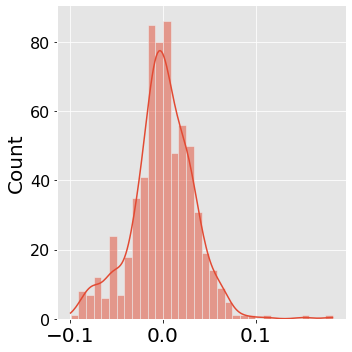

In [56]:
# the residual of OLS is t-distributed
resid = np.array(results.resid)
sb.displot(resid, kde=True)
d_freedom, location, scale = stats.t.fit(resid)
print(d_freedom, location, scale)
test_cdf = stats.t(df=d_freedom, loc=location, scale=scale).cdf
stats.kstest(resid, test_cdf)

# Influence of architecture

In [57]:
vgg_df = df[df['is_vgg']==1].copy(deep=True).reset_index(drop=True)
inception_df = df[df['is_inception']==1].copy(deep=True).reset_index(drop=True)
resnet_df = res_df[(res_df['is_Pretrained']==1) & (res_df['is_raw']==1) & (res_df['is_18']==1)].copy(deep=True).reset_index(drop=True)
arch_df = pd.concat([vgg_df, inception_df, resnet_df], axis=0).reset_index(drop=True)
arch_df = arch_df.rename(columns={'is_inception':'is_Inception_V3', 'is_vgg':'is_VGG_16', 'is_resnet':'is_ResNet_18'})
arch_df.to_csv('imagenet_arch_df.csv')
arch_df

,misclassification_rate,matching_rate,Unnamed: 10,is_Pretrained,is_ResNet_18,is_Inception_V3,is_VGG_16,is_raw,is_augmented,is_adversarial,...,is_RFGSM,is_LLC,is_BLB,is_google,is_aliyun,is_aws,is_baidu,is_18,is_34,is_50
0,0.005000,0.115000,NaN,1,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,0.005000,0.115000,NaN,1,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.005291,0.153439,NaN,1,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.174825,0.125874,NaN,1,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.044199,0.066298,NaN,1,0,0,1,1,0,0,...,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.058201,0.010582,NaN,1,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
104,0.075000,0.070000,NaN,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
105,0.071429,0.066327,NaN,1,1,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
106,0.095238,0.047619,NaN,1,1,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [58]:
# regression w.r.t. architecture
exp_vs = [ 'is_google', 'is_aws', 'is_baidu', 'is_aliyun', ]

dp_variable = 'misclassification_rate'
formula = '{} ~ 0+{}'.format(dp_variable, '+'.join(exp_vs))

# add cross terms to formula

formula += '+' + '+'.join([f'I({model}*{attr})' for model in ['is_VGG_16', 'is_Inception_V3'] for attr in ['is_PGD', 'is_FGSM', 'is_BLB', 'is_CW2', 'is_DEEPFOOL', 'is_STEP_LLC', 'is_RFGSM', 'is_LLC',]])
# formula += '+' + '+'.join([f'is_Pretrained*{attr}' for attr in ['is_adversarial', 'is_PGD', 'is_BLB', 'is_CW2', 'is_DEEPFOOL',  'is_RFGSM', ]])

print(formula)
model = ols(formula, data=arch_df)
results = model.fit()
export_ols(results, './ols_result/ols_arch.csv')
results.summary()

misclassification_rate ~ 0+is_google+is_aws+is_baidu+is_aliyun+I(is_VGG_16*is_PGD)+I(is_VGG_16*is_FGSM)+I(is_VGG_16*is_BLB)+I(is_VGG_16*is_CW2)+I(is_VGG_16*is_DEEPFOOL)+I(is_VGG_16*is_STEP_LLC)+I(is_VGG_16*is_RFGSM)+I(is_VGG_16*is_LLC)+I(is_Inception_V3*is_PGD)+I(is_Inception_V3*is_FGSM)+I(is_Inception_V3*is_BLB)+I(is_Inception_V3*is_CW2)+I(is_Inception_V3*is_DEEPFOOL)+I(is_Inception_V3*is_STEP_LLC)+I(is_Inception_V3*is_RFGSM)+I(is_Inception_V3*is_LLC)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     misclassification_rate   R-squared:                       0.876
Model:                                OLS   Adj. R-squared:                  0.849
Method:                     Least Squares   F-statistic:                     32.77
Date:                    Tue, 15 Mar 2022   Prob (F-statistic):           7.52e-32
Time:                            21:16:16   Log-Likelihood:                 221.55
No. Observations:                     108   AIC:                            -403.1
Df Residuals:                          88   BIC:                            -349.5
Df Model:                              19                                         
Covariance Type:                nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
is_google                            0.2184      0.008     28.206      0.000       0.203       0.234
is_aws                               0.0579      0.008      7.480      0.000       0.043       0.073
is_baidu                             0.1659      0.008     21.416      0.000       0.150       0.181
is_aliyun                            0.0499      0.008      6.437      0.000       0.034       0.065
I(is_VGG_16 * is_PGD)                0.0257      0.018      1.430      0.156      -0.010       0.062
I(is_VGG_16 * is_FGSM)               0.0986      0.018      5.477      0.000       0.063       0.134
I(is_VGG_16 * is_BLB)               -0.0287      0.018     -1.594      0.115      -0.064       0.007
I(is_VGG_16 * is_CW2)               -0.0377      0.018     -2.097      0.039      -0.074      -0.002
I(is_VGG_16 * is_DEEPFOOL)          -0.0306      0.018     -1.702      0.092      -0.066       0.005
I(is_VGG_16 * is_STEP_LLC)           0.1082      0.018      6.010      0.000       0.072       0.144
I(is_VGG_16 * is_RFGSM)              0.0229      0.018      1.271      0.207      -0.013       0.059
I(is_VGG_16 * is_LLC)                0.0012      0.018      0.064      0.949      -0.035       0.037
I(is_Inception_V3 * is_PGD)         -0.0056      0.018     -0.309      0.758      -0.041       0.030
I(is_Inception_V3 * is_FGSM)         0.0915      0.018      5.082      0.000       0.056       0.127
I(is_Inception_V3 * is_BLB)         -0.0263      0.018     -1.462      0.147      -0.062       0.009
I(is_Inception_V3 * is_CW2)         -0.0280      0.018     -1.553      0.124      -0.064       0.008
I(is_Inception_V3 * is_DEEPFOOL)    -0.0310      0.018     -1.723      0.088      -0.067       0.005
I(is_Inception_V3 * is_STEP_LLC)     0.1092      0.018      6.067      0.000       0.073       0.145
I(is_Inception_V3 * is_RFGSM)        0.0288      0.018      1.603      0.113      -0.007       0.065
I(is_Inception_V3 * is_LLC)         -0.0060      0.018     -0.336      0.738      -0.042       0.030
==============================================================================
Omnibus:                       25.945   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.736
Skew:                           1.034   Prob(JB):                     1.93e-10
Kurtosis:                       5.380   Cond. No.                         4.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

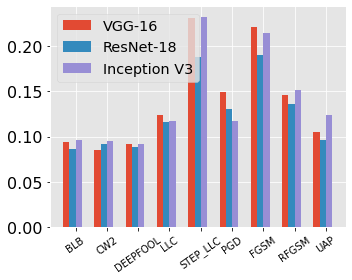

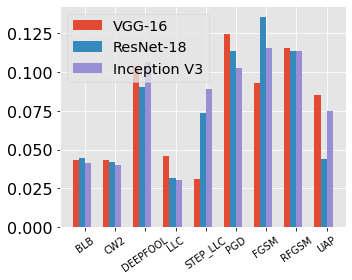

In [59]:
for metric in ['misclassification_rate', 'matching_rate']:
    architectures = ['VGG_16', 'ResNet_18', 'Inception_V3']
    attacks = ['BLB', 'CW2', 'DEEPFOOL', 'LLC', 'STEP_LLC', 'PGD', 'FGSM', 'RFGSM', 'UAP']

    arch_data = {'VGG_16':[], 'ResNet_18':[], 'Inception_V3':[]}
    for arch in architectures:
        for attack in attacks:
            point = arch_df[(arch_df[f'is_{attack}']==1) & (arch_df[f'is_{arch}']==1)][metric].mean()
            arch_data[arch].append(point)

    fig, ax = plt.subplots(figsize=(5,4))
    plt.xticks([i for i in range(len(attacks))], attacks, rotation=35, fontsize=10)
    x = np.arange(len(attacks))
    width = 0.2
    ax.bar(x-1.5*width, arch_data['VGG_16'], width, label='VGG-16')
    ax.bar(x-0.5*width,arch_data['ResNet_18'], width, label='ResNet-18')
    ax.bar(x+0.5*width,arch_data['Inception_V3'],width,label='Inception V3')
    plt.tight_layout()
    plt.legend()
    # plt.savefig(f'{save_dir}/cross_architecture_{metric}.eps', format="eps", bbox_inches = 'tight')
        
